8
 0 : 128 dots
 1 : 50 dots
 2 : 20 dots
 3 : 24 dots
 4 : 11 dots
 5 : 11 dots
 6 : 11 dots
 7 : 11 dots


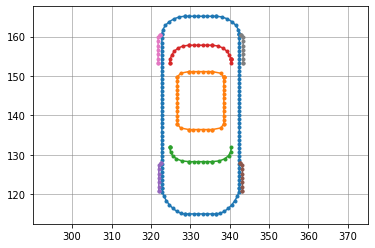

label size = 1
(128, 16)


In [48]:
## Python basics for novice data scientists, supported by Wagatsuma Lab@Kyutech 
#
# The MIT License (MIT): Copyright (c) 2021 Hiroaki Wagatsuma and Wagatsuma Lab@Kyutech
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE. */
#
# # @Time    : 2021-1-16 
# # @Author  : Hiroaki Wagatsuma
# # @Site    : https://github.com/hirowgit/2B0_python_optmization_course
# # @IDE     : Python 3.7.7 (default, Mar 10 2020, 15:43:27) [Clang 10.0.0 (clang-1000.11.45.5)] on darwin
# # @File    : SVG_converter_Gold.py

import numpy as np
import matplotlib.pyplot as plt
import os

from svg.path import parse_path
from svg.path.path import Line
from xml.dom import minidom

from time import time
import pandas as pd

def line_splitter(start, end):
    return (lambda t: (1-t)*start+t*end)

def cubic_bezier_converter(start, control1, control2, end):
    original_data = np.array([start, control1, control2, end])
    cubic_bezier_matrix = np.array([
        [-1,  3, -3,  1],
        [ 3, -6,  3,  0],
        [-3,  3,  0,  0],
        [ 1,  0,  0,  0]
    ])
    return_data = cubic_bezier_matrix.dot(original_data)

    return (lambda t: np.array([t**3, t**2, t, 1]).dot(return_data))

# On the design of "cubic_bezier_converter" was learned from
# https://stackoverflow.com/questions/36971363/how-to-interpolate-svg-path-into-a-pixel-coordinates-not-simply-raster-in-pyth
datafol_in='data'
datafol_out='output'

inputF='B_sample.svg'
inputF='LaneMap2.svg'
inputF='CarShapeF.svg'

doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
doc.unlink()

points_np_all=[]
points_np_all=np.empty((len(path_strings)),dtype=object)
print(len(points_np_all))

for k in range(len(path_strings)):
#for path_string in path_strings:
    path = parse_path(path_strings[k])
    points_np_merge=np.empty((0,2), float)
    for dat in path:
        if type(dat).__name__=='CubicBezier':
            start_np = np.array([dat.start.real, dat.start.imag])
            control1_np = np.array([dat.control1.real, dat.control1.imag])
            control2_np = np.array([dat.control2.real, dat.control2.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            converted_curve = cubic_bezier_converter(start_np, control1_np, control2_np, end_np)
            # 
            diff_np=start_np-end_np
            n_dots=np.round(np.linalg.norm(diff_np)).astype(int)
            # 
            points_np = np.array([converted_curve(t) for t in np.linspace(0, 1, n_dots)])
        elif type(dat).__name__=='Line':
            start_np = np.array([dat.start.real, dat.start.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            converted_line = line_splitter(start_np,end_np)
            # 
            diff_np=start_np-end_np
            n_dots=np.round(np.linalg.norm(diff_np)).astype(int)
            #     
            points_np=np.array([converted_line(t) for t in np.linspace(0, 1, n_dots)])
        elif type(dat).__name__=='Move':
            # 
            n_dots=1
            # 
            start_np = np.array([dat.start.real, dat.start.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            points_np = np.array([start_np,end_np])
        else:
            points_np=np.array([])
        #points_np_merge=np.concatenate(points_np_merge,points_np)
        if np.shape(points_np)[0]>0:
                points_np_merge=np.append(points_np_merge, points_np, axis=0)
    points_np_all[k]= points_np_merge
    print(' %d : %d dots' % (k,len(points_np_merge)))

len(points_np_all)

fig1, ax = plt.subplots()
# plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.grid(color=[0.5,0.5,0.5], linestyle='-', linewidth=0.5)

for k in range(len(points_np_all)):
    points_np=points_np_all[k]
    plt.plot(points_np[:, 0], points_np[:, 1], '.-')
ax.axis('equal')
plt.show()

maxL=max(len(points_np_all[k]) for k in range(len(points_np_all)))

label=np.empty([],dtype='unicode')
print("label size = %d" % (label.size))
label=[]
for k in range(len(points_np_all)): 
    label=np.append(label,["x%d"%(k+1),"y%d"%(k+1)])
dat_df = pd.DataFrame([],columns=label)
for k in range(len(points_np_all)):
    points_np=points_np_all[k]
    tmp0=np.zeros([maxL,2])
    tmp0[0:points_np.shape[0],:]=points_np
    dat_df["x%d"%(k+1)] = tmp0[:,0]
    dat_df["y%d"%(k+1)] = tmp0[:,1]
    
print(dat_df.shape)
dat_df

outF=inputF.split('.')[0]+'.csv'
dat_df.to_csv(os.path.join(datafol_out,outF))

In [ ]:
## Python basics for novice data scientists, supported by Wagatsuma Lab@Kyutech 
#
# The MIT License (MIT): Copyright (c) 2021 Hiroaki Wagatsuma and Wagatsuma Lab@Kyutech
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE. */
#
# # @Time    : 2021-1-16 
# # @Author  : Hiroaki Wagatsuma
# # @Site    : https://github.com/hirowgit/2B0_python_optmization_course
# # @IDE     : Python 3.7.7 (default, Mar 10 2020, 15:43:27) [Clang 10.0.0 (clang-1000.11.45.5)] on darwin
# # @File    : SVG_converter_Gold.py

import numpy as np
import matplotlib.pyplot as plt
import os

from svg.path import parse_path
from svg.path.path import Line
from xml.dom import minidom

from time import time
import pandas as pd

def line_splitter(start, end):
    return (lambda t: (1-t)*start+t*end)

def cubic_bezier_converter(start, control1, control2, end):
    original_data = np.array([start, control1, control2, end])
    cubic_bezier_matrix = np.array([
        [-1,  3, -3,  1],
        [ 3, -6,  3,  0],
        [-3,  3,  0,  0],
        [ 1,  0,  0,  0]
    ])
    return_data = cubic_bezier_matrix.dot(original_data)

    return (lambda t: np.array([t**3, t**2, t, 1]).dot(return_data))

# On the design of "cubic_bezier_converter" was learned from
# https://stackoverflow.com/questions/36971363/how-to-interpolate-svg-path-into-a-pixel-coordinates-not-simply-raster-in-pyth
datafol_in='data'
datafol_out='output'

inputF='B_sample.svg'
inputF='LaneMap2.svg'
inputF='CarShapeF.svg'
# inputF='BY_ASS.svg'

In [163]:


doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
# path_strings = [path.getAttribute('d') for path
#                 in doc.getElementsByTagName('polyline')]
doc.unlink()

# KL=3
points_np_all2=[]
points_np_all=np.empty((len(path_strings)),dtype=object)
# points_np_all=np.empty((KL),dtype=object)
print(len(points_np_all))

for k in range(len(path_strings)):
# for k in range(KL):
#for path_string in path_strings:
    path = parse_path(path_strings[k])
    points_np_merge=np.empty((0,2), float)
#     k2=1
    for dat in path:
#         print([str(k2),type(dat).__name__])
        if type(dat).__name__=='CubicBezier':
#             print('CubicBezier')
            start_np = np.array([dat.start.real, dat.start.imag])
            control1_np = np.array([dat.control1.real, dat.control1.imag])
            control2_np = np.array([dat.control2.real, dat.control2.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            converted_curve = cubic_bezier_converter(start_np, control1_np, control2_np, end_np)
            # 
            diff_np=start_np-end_np
            n_dots=np.round(np.linalg.norm(diff_np)).astype(int)
            # 
            points_np = np.array([converted_curve(t) for t in np.linspace(0, 1, n_dots)])
        elif type(dat).__name__=='Line':
#             print('Line')
            start_np = np.array([dat.start.real, dat.start.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            converted_line = line_splitter(start_np,end_np)
            # 
            diff_np=start_np-end_np
            n_dots=np.round(np.linalg.norm(diff_np)).astype(int)
            #     
            points_np=np.array([converted_line(t) for t in np.linspace(0, 1, n_dots)])
        elif type(dat).__name__=='Move':
#             print('Move')
            # 
            n_dots=1
            # 
            start_np = np.array([dat.start.real, dat.start.imag])
            end_np = np.array([dat.end.real, dat.end.imag])
            points_np = np.array([start_np,end_np])
        else:
            points_np=np.array([])
        #points_np_merge=np.concatenate(points_np_merge,points_np)
        if np.shape(points_np)[0]>0:
                points_np_merge=np.append(points_np_merge, points_np, axis=0)
#         k2=k2+1
    points_np_all[k]= points_np_merge
    print(' %d : %d dots' % (k,len(points_np_merge)))

points_np_all2=points_np_all

8
 0 : 128 dots
 1 : 50 dots
 2 : 20 dots
 3 : 24 dots
 4 : 11 dots
 5 : 11 dots
 6 : 11 dots
 7 : 11 dots


In [158]:
# points_np_all[1]

In [159]:
# aa=np.append(points_np_all,points_np_all)
# len(aa)
# points_np_all2

In [164]:
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('points') for path
                in doc.getElementsByTagName('polyline')]
# path_strings = [path.getAttribute('d') for path
#                 in doc.getElementsByTagName('polyline')]
doc.unlink()

points_np_merge=[]
points_np_all=np.empty((len(path_strings)),dtype=object)

for k in range(len(path_strings)):
    kd=path_strings[k]
    pointD=[d.split(',') for d in kd.split(' ') if len(d)>0]
#     points_np=np.array([[float(d[0]),float(d[1])] for d in pointD])
    points_np=np.array([[float(d[0]),float(d[1])] for d in pointD])
    points_np_all[k]=points_np
#     points_np_all[k]= np.append(points_np_merge, points_np, axis=0)
#     points_np_all[k]= points_np_merge

# print(points_np_all)
    
points_np_all2=np.append(points_np_all2,points_np_all)
# points_np_all2

In [165]:
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [[path.getAttribute('x1'),path.getAttribute('y1'),path.getAttribute('x2'),path.getAttribute('y2')]  for path
                in doc.getElementsByTagName('line')]
doc.unlink()
path_strings


points_np_merge=[]
points_np_all=np.empty((len(path_strings)),dtype=object)

for k in range(len(path_strings)):
    kd=path_strings[k]
    points_np=np.array([[float(kd[0]),float(kd[1])],[float(kd[2]),float(kd[3])]])
    points_np_all[k]=points_np
    
# print(points_np_all)    
points_np_all2=np.append(points_np_all2,points_np_all)
# points_np_all2

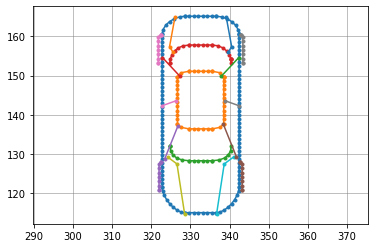

label size = 1
(128, 36)


In [166]:
points_np_all=points_np_all2
len(points_np_all)

fig1, ax = plt.subplots()
# plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.grid(color=[0.5,0.5,0.5], linestyle='-', linewidth=0.5)

for k in range(len(points_np_all)):
    points_np=points_np_all[k]
    plt.plot(points_np[:, 0], points_np[:, 1], '.-')
ax.axis('equal')
plt.show()

maxL=max(len(points_np_all[k]) for k in range(len(points_np_all)))

label=np.empty([],dtype='unicode')
print("label size = %d" % (label.size))
label=[]
for k in range(len(points_np_all)): 
    label=np.append(label,["x%d"%(k+1),"y%d"%(k+1)])
dat_df = pd.DataFrame([],columns=label)
for k in range(len(points_np_all)):
    points_np=points_np_all[k]
    tmp0=np.zeros([maxL,2])
    tmp0[0:points_np.shape[0],:]=points_np
    dat_df["x%d"%(k+1)] = tmp0[:,0]
    dat_df["y%d"%(k+1)] = tmp0[:,1]
    
print(dat_df.shape)
dat_df

outF=inputF.split('.')[0]+'.csv'
dat_df.to_csv(os.path.join(datafol_out,outF))

In [156]:
d=kd
[[float(d[0]),float(d[1])],[float(d[2]),float(d[3])]]

[[337.893, 149.824], [342.367, 154.619]]

In [151]:
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [[path.getAttribute('x1'),path.getAttribute('y1'),path.getAttribute('x2'),path.getAttribute('y2')]  for path
                in doc.getElementsByTagName('line')]
doc.unlink()
path_strings

[['337.893', '149.824', '342.367', '154.619'],
 ['327.342', '149.824', '322.867', '154.619'],
 ['323.451', '128.73', '326.783', '137.04'],
 ['341.783', '129.209', '338.449', '137.52'],
 ['322.83', '142.314', '326.402', '143.592'],
 ['342.402', '142.314', '338.832', '143.592']]

In [137]:
points_np_merge=[]
points_np=np.array(points_np)
np.shape(points_np)
np.vstack([points_np,points_np])
# np.vstack(points_np, points_np)

array([[328.533, 114.667],
       [326.582, 127.426],
       [324.199, 129.209],
       [328.533, 114.667],
       [326.582, 127.426],
       [324.199, 129.209]])

In [118]:
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('points') for path
                in doc.getElementsByTagName('polyline')]
# path_strings = [path.getAttribute('d') for path
#                 in doc.getElementsByTagName('polyline')]
doc.unlink()
path_strings

['328.533,114.667 326.582,127.426 324.199,129.209   ',
 '336.701,114.667 338.65,127.426 341.033,129.209   ',
 '339.182,164.851 340.551,157.404 339.713,156.058   ',
 '326.051,164.851 324.682,157.404 325.52,156.058   ']

In [105]:
pointD=[d.split(',') for d in kd.split(' ') if len(d)>0]
pointD_np=np.array([[float(d[0]),float(d[1])] for d in pointD])
pointD_np
# pointD

array([[326.051, 164.851],
       [324.682, 157.404],
       [325.52 , 156.058]])

In [11]:
inputF.split('.')[0]+'.csv'

'CarShapeF.csv'

In [ ]:
        disp([str(),type(dat).__name__])


In [42]:
path

Path(Move(to=(324.797+131.925j)), Line(start=(324.797+131.925j), end=(324.797+131.925j)), CubicBezier(start=(324.797+131.925j), control1=(324.797+129.89600000000002j), control2=(326.24+128.25j), end=(329.774+128.25j), smooth=False), Line(start=(329.774+128.25j), end=(335.46+128.25j)), CubicBezier(start=(335.46+128.25j), control1=(338.993+128.25j), control2=(340.43699999999995+129.896j), end=(340.43699999999995+131.925j), smooth=False), Line(start=(340.43699999999995+131.925j), end=(340.43699999999995+131.925j)))

In [28]:
path[1]

Line(start=(342.826+160.498j), end=(342.826+160.498j))

In [52]:
doc.getElementsByTagName('line')

[]

In [57]:
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
doc.unlink()
path_strings

['M342.449,160.546c0,2.553-3.156,4.621-5.818,4.621h-8.027   c-2.662,0-5.82-2.068-5.82-4.621v-39.021c0-2.551,3.158-6.538,5.82-6.538h8.027c2.662,0,5.818,3.987,5.818,6.538V160.546z',
 'M338.518,149.754c0,0.748-1.295,1.354-2.893,1.354h-6.018   c-1.598,0-2.893-0.606-2.893-1.354v-11.998c0-0.748,1.295-1.354,2.893-1.354h6.018c1.598,0,2.893,0.607,2.893,1.354V149.754z',
 'M324.797,131.925L324.797,131.925c0-2.029,1.443-3.675,4.977-3.675   h5.686c3.533,0,4.977,1.646,4.977,3.675l0,0',
 'M340.436,154.299v-0.959c0,1.941-1.443,4.476-4.977,4.476h-5.686   c-3.533,0-4.977-2.534-4.977-4.476v0.959',
 'M322.567,127.999L322.567,127.999c-0.317,0-0.574-0.261-0.574-0.583   v-6.667c0-0.322,0.257-0.583,0.574-0.583l0,0',
 'M342.666,127.999L342.666,127.999c0.317,0,0.574-0.261,0.574-0.583   v-6.667c0-0.322-0.257-0.583-0.574-0.583l0,0',
 'M322.408,160.498L322.408,160.498c-0.322,0-0.584-0.261-0.584-0.583   v-6.667c0-0.322,0.262-0.583,0.584-0.583l0,0',
 'M342.826,160.498L342.826,160.498c0.322,0,0.582-0.261,0.582-0.583 

In [58]:
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [path.getAttribute('points') for path
                in doc.getElementsByTagName('polyline')]
doc.unlink()
path_strings

['328.533,114.667 326.582,127.426 324.199,129.209   ',
 '336.701,114.667 338.65,127.426 341.033,129.209   ',
 '339.182,164.851 340.551,157.404 339.713,156.058   ',
 '326.051,164.851 324.682,157.404 325.52,156.058   ']

In [60]:
doc = minidom.parse(os.path.join(datafol_in,inputF))
path_strings = [[path.getAttribute('x1'),path.getAttribute('y1'),path.getAttribute('x2'),path.getAttribute('y2')]  for path
                in doc.getElementsByTagName('line')]
doc.unlink()
path_strings

[['337.893', '149.824', '342.367', '154.619'],
 ['327.342', '149.824', '322.867', '154.619'],
 ['323.451', '128.73', '326.783', '137.04'],
 ['341.783', '129.209', '338.449', '137.52'],
 ['322.83', '142.314', '326.402', '143.592'],
 ['342.402', '142.314', '338.832', '143.592']]